In [1]:
from typing import Union

from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import QuantumRegister, ClassicalRegister, AncillaRegister
from numpy import pi
# uncomment to check version
# import qiskit
# print(qiskit.__version__)

provider = IBMQ.load_account()


In [2]:
# Number of shots
shots = 1

# Choose a device
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# Run on quantum computer
# backend = provider.get_backend('ibmq_vigo')

# OR

# run on simulating Backend
simulator = Aer.get_backend('qasm_simulator')

In [3]:
def require_not_empty(reg: Union[QuantumRegister, AncillaRegister, ClassicalRegister]):
    if len(reg) < 1:
        raise Exception("Register is required to be not empty")
    return reg


def get_black_box(black_box_type: str):
    """returns one of the 4 possible functions (black box) between:
    `zero-constant` f(0) = f(1) = 0
    `one-constant` f(0) = f(1) = 1
    `balanced` f(0) = 0, f(1) = 1
    `inv-balanced` f(0) = 1, f(1) = 0

    It's job is to add the result of the function applied to the qubit
    to the ancilla:
    ancilla = ancilla + f(qubit)
    
    :param str type: parameter selecting which function to generate
    """
    if black_box_type == "zero-constant":
        def zero_constant(circuit: QuantumCircuit, q_reg: QuantumRegister, ancilla_reg: AncillaRegister):
            pass
        return zero_constant
    elif black_box_type == "one-constant":
        def one_constant(circuit: QuantumCircuit, q_reg: QuantumRegister, ancilla_reg: AncillaRegister):
            require_not_empty(q_reg)
            require_not_empty(ancilla_reg)
            circuit.x(ancilla_reg[0])
        return one_constant
    elif black_box_type == "balanced":
        def balanced(circuit: QuantumCircuit, q_reg: QuantumRegister, ancilla_reg: AncillaRegister):
            require_not_empty(q_reg)
            require_not_empty(ancilla_reg)
            circuit.cx(q_reg[0], ancilla_reg[0])
        return balanced
    elif black_box_type == "inv-balanced":
        def inv_balanced(circuit: QuantumCircuit, q_reg: QuantumRegister, ancilla_reg: AncillaRegister):
            require_not_empty(q_reg)
            require_not_empty(ancilla_reg)
            circuit.cx(q_reg[0], ancilla_reg[0])
            circuit.cx(ancilla_reg[0])
        return inv_balanced


In [15]:
# Initialize Circuit
quantum_reg = QuantumRegister(1, "q")
ancilla_reg = AncillaRegister(1, "a")
classical_reg = ClassicalRegister(1, "c")

circ = QuantumCircuit(quantum_reg, ancilla_reg, classical_reg, name="Deutch-Jozsa")

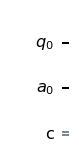

In [16]:
# Draw Circuit
circ.draw(output='mpl')

In [17]:
blackbox = get_black_box("balanced")

# step 1: 00 -> 01
circ.x(ancilla_reg[0]) 

# step 2: 01 -> +-
circ.h(quantum_reg[0]) 
circ.h(ancilla_reg[0])

# BlackBox
blackbox(circ, quantum_reg, ancilla_reg)

# Hadamard
circ.h(quantum_reg[0]) 
# circ.h(ancilla_reg[0])

Total count: {'1': 1}
1 : 1.0


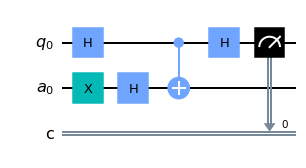

In [18]:
circ.measure(quantum_reg[0], classical_reg[0])

job = execute(circ, backend=simulator, shots=shots)
result = job.result()

# Returns counts
data = result.get_counts(circ)

# Print data 
print("Total count:", data)

for l in data.keys():
    print(f"{l} : {data[l]/shots}")

# draw circuit
circ.draw(output='mpl')

## Results
Obtaining a 0 means that the function is constant, any other state means the function is balanced